# Quantum teleportation

We may not be able to clone arbitrary quantum states, but we can do something arguably cooler - we can teleport them! If Alice and Bob share an entangled pair of qubits in the state
\begin{equation}
 |\Psi\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11 \rangle \right),
\end{equation}
then they can use it to transfer the state of a third qubit to Bob.

**Important!** Teleportation does not mean that the physical qubit held by Alice is being shipped to Bob. Rather, the _state_ of Alice's qubit will be 'transferred' to the qubit held by Bob following the protocol.

In [2]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import execute, BasicAer

import qiskit.tools.visualization as qvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

First we'll set up the qubit registers and the circuit.

In [3]:
# Set up the quantum circuit; Alice holds qubits 0 and 1, and Bob has qubit 2
# We need quantum register with 3 qubits, and classical register with 2 qubits
alice = QuantumRegister(2, 'a')
bob = QuantumRegister(1, 'b')
measurement_0 = ClassicalRegister(1, 'm0')
measurement_1 = ClassicalRegister(1, 'm1')

teleportation = QuantumCircuit(alice, bob, measurement_0, measurement_1)

Next we'll give Alice a random initial state to teleport. We'll do so by sending randomly chosen angles as parameters to a general unitary rotation gate.

In [4]:
# Prepare a random single-qubit state that we would like to send
random_angles = np.random.rand(3)
teleportation.u3(*random_angles, alice[0])

teleportation.draw()

Let's see on the Bloch sphere where this state is...

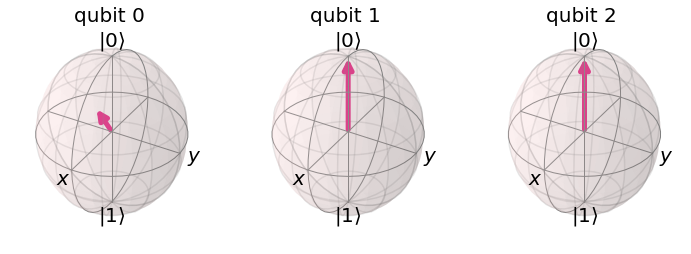

In [6]:
# To plot the Bloch vectors we will have to extract the state from the 
# statevector simulator.
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(teleportation, backend).result()
initial_psi  = result.get_statevector(teleportation)

qvis.plot_bloch_multivector(initial_psi)

Note that qubit 1 and qubit 2 are still in state $|0\rangle$; our next step is to prepare the shared entangled state. 

In [7]:
# Prepare an entangled state for Alice and Bob to share
teleportation.h(alice[1])
teleportation.cx(alice[1], bob[0])

teleportation.draw()

Now that everything is set up, to teleport the qubit, Alice is going to entangle the qubit she wants to send with the qubit she holds from the entangled pair.

In [8]:
# Now entangle Alice's first qubit with the first qubit of shared Bell state
teleportation.cx(alice[0], alice[1])
teleportation.h(alice[0])

teleportation.draw()

Next she will measure both her qubits, giving her two classical bits.

In [9]:
# Execute circuit and get 2 measurement outcomes
teleportation.measure(alice[0], measurement_0[0])
teleportation.measure(alice[1], measurement_1[0])

teleportation.draw()

Alice phones Bob and tells him what bits she measured. Based on the outcomes, Bob will apply some Pauli gates to his half of the entangled state:
\begin{eqnarray}
 00 &\rightarrow& I \\
 01 &\rightarrow& X \\
 10 &\rightarrow& Z \\
 11 &\rightarrow& ZX
\end{eqnarray}
In the circuit these can be expressed as controlled gates using the classical outcomes as controls rather than normal qubits.

In [10]:
# Based on outcomes, apply X, Z, or XZ
teleportation.x(bob[0]).c_if(measurement_1, 1)
teleportation.z(bob[0]).c_if(measurement_0, 1)

teleportation.draw()

After Bob applies his Paulis, his qubit will be in exactly the same state as the one Alice prepared! Let's plot the Bloch vectors to make sure.

In [11]:
# Execute the full circuit
result = execute(teleportation, backend).result()
final_psi  = result.get_statevector(teleportation)

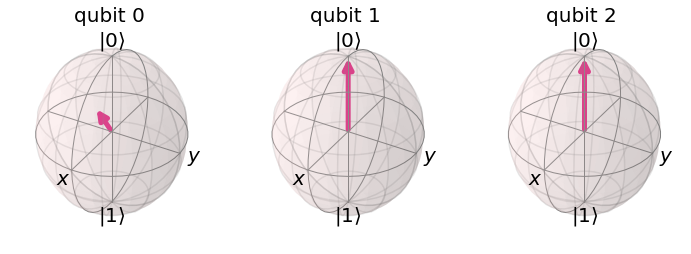

In [12]:
qvis.plot_bloch_multivector(initial_psi)

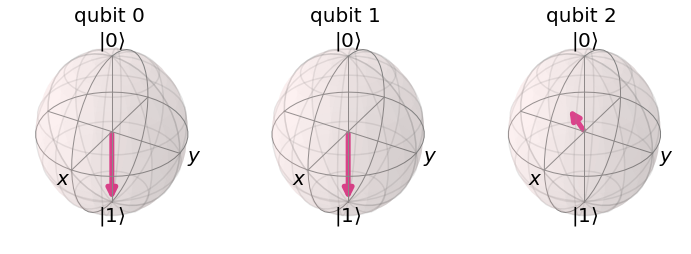

In [13]:
qvis.plot_bloch_multivector(final_psi)

Qubit 2, Bob's qubit, matches the initial state of Alice's qubit 0. Note that after the protocol, Alice's two qubits will be sitting in whatever states correspond to her classical measurement outcomes.   

**Exercise**: starting from the state
\begin{equation}
 \left( \alpha |0\rangle + \beta |1 \rangle \right) \otimes \frac{1}{\sqrt{2}} \left( |00\rangle + |11 \rangle \right),
\end{equation}
work through the teleportation protocol to see how Alice's state gets transferred to Bob. You'll have to expand everything, then perform a basis change on Alice's two qubits to shift them into the Bell basis. After, Alice performs the CNOT and H before measuring; this changes back to the computational basis so we can interpret the measurements more easily. You'll see, after this transformation, each of the computational basis states will be attached to a slightly different version of the original state in Bob's qubit, which can easily be undone with the Pauli operators.